<a href="https://colab.research.google.com/github/drambaut/Aprendizaje_aplicado_a_teoria_control/blob/main/ML_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prueba para la optención de datos para el entrenamiento de modelos de ML como controladores.

Basado en el blog [Emulating a PID Controller ...](https://towardsdatascience.com/emulating-a-pid-controller-with-long-short-term-memory-part-1-bb5b87165b08)

In [1]:
import random
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Limite controlador
COHI = 0.1
COLO = -0.1

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Ecuación del calor

Situación
* t es el tiempo
 
* T(t) es la temperatura del salón (que deseamos que esté cerca a 20ºC) en  el tiempo t

* Ta(t) es la temperatura ambiente en el tiempo t (puede asumirse constante por ahora)

* c(t) es la potencia de calefacción aplicada al salón en el tiempo t.

El modelo es el siguiente: 
                dT(t)/dt = (Ta(t)-T(t))+c(t)
                dc(t)/dt = q(t)

siendo q(t) la entrada de control (variable cuyo valor debería decidir el algoritmo de inteligencia artificial).  

La variable q(t) puede entenderse como la acción de subir o bajar la potencia de calefacción. Si q(t) es positiva, entonces la potencia de  calefacción sube con una velocidad proporcional al valor de q(t). Si q(t) es negativa, entonces la potencia de calefacción baja a una velocidad proporcional al valor de -q(t).

In [3]:
def tempModel(t, state, Ta, q):
    T, c = state

    dT = (Ta - T) + c
    dc = q

    return [dT, dc]

In [4]:
# Parámetros
Ta = 34
q = 0

p = (Ta, q)
state0 = [33, 0]
t_spam = [0, 1]

# Resolver
res = solve_ivp(tempModel, t_spam, state0, args=p)

In [5]:
res

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.21567928, 1.        ])
 t_events: None
        y: array([[33.        , 33.19400621, 33.63204186],
       [ 0.        ,  0.        ,  0.        ]])
 y_events: None

In [6]:
# Iterate q
# Parámetros
Ta = 34
state0 = [33, 0]
t_spam = [0, 1]

q_eval = np.arange(COLO, COHI, 0.1)
T_sol = []
for q in q_eval:
    p = (Ta, q)
    res = solve_ivp(tempModel, t_spam, state0, args=p)
    T_sol.append(res.y[0][-1])

In [7]:
Tsp = 25 # Temperatura objetivo
min_pos = np.argmin(np.array(T_sol) - Tsp)
q_opt = q_eval[min_pos]
print(f'Mejor elección de control: {q_opt}')
print(f'Temperatura en el siguiente paso: {T_sol[min_pos]}')

Mejor elección de control: -0.1
Temperatura en el siguiente paso: 33.59511883860729


## PID Controller

In [8]:
def pid(sp,pv,pv_last,ierr,dt):
    '''
    sp: setpoint
    pv: point value
    '''
    # PID Parameters
    Kc   = 0.5
    tauI = 7.5 # sec
    tauD = 0.0  # sec
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD

    # OPbias for controller (initial heater)
    op0 = 0
    # upper and lower bounds on heater level(Controller)
    ophi = COHI
    oplo = COLO
    
    # error
    error = sp - pv

    # calculate the integral error
    ierr = ierr + KI * error * dt

    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt

    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D # Output

    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    
    return op, P, I, D

# Temperaturas objetivo para testear

Generador de datos

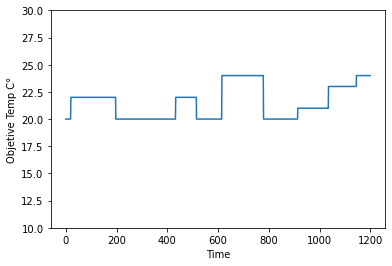

In [9]:
  ##### Set up run parameters #####
# Run time in minutes
run_time = 20.0

# Number of cycles
loops = int(60.0*run_time)

# Temperature set point (degC)
Tsp1 = np.ones(loops) * 20.0

# vary temperature setpoint
end = 20 # leave 1st 20 seconds of temp setpoint as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 1 to 3 min
    end += random.randint(80, 180) 
    Tsp1[start:end] = random.randint(20,24)

plt.plot(Tsp1)
plt.ylim((10, 30))
plt.ylabel('Objetive Temp C°'); plt.xlabel('Time')
plt.show()

Cargar datos de referencia

In [10]:
setpoint_ref = pd.read_csv('setpoint.csv', names=['index', 'setpoint'], skiprows=1)
setpoint = setpoint_ref['setpoint']

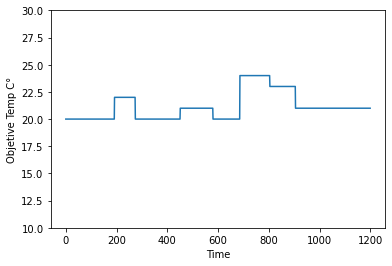

In [11]:
plt.plot(setpoint)
plt.ylim((10, 30))
plt.ylabel('Objetive Temp C°'); plt.xlabel('Time')
plt.show()

Experimento con grilla de opciones como control

In [12]:
%%time
# Parámetros
Ta = 25 # Se asume constante
state = [34, 0] # Inicial
t_spam = [0, 1]
Tsp1 = setpoint
q_eval = np.arange(COLO, COHI, abs(COHI - COLO)/10)
q_eval[int(len(q_eval)/2)] = 0 # Forzar el 0

# arrays for storing data
Temperature_grid = np.zeros(loops) # measured T (degC)
error_grid = np.zeros(loops) # Setpoint error
Q1_grid = np.zeros(loops) # Controller values

for i in range(loops):
    # Guardar temperatura
    Temperature_grid[i] = state[0]
    # Absolute error
    error_grid[i] =  np.abs(Tsp1[i]-Temperature_grid[i])

    # Obtener control y nuevo estado
    T_sol = []
    c_sol = []
    for q in q_eval:
        p = (Ta, q)
        res = solve_ivp(tempModel, t_spam, state, args=p)
        T_sol.append(res.y[0][-1])
        c_sol.append(res.y[1][-1])

    min_pos = np.argmin(np.abs(np.array(T_sol) - Tsp1[i])) # Obtener error mínimo
    state = [T_sol[min_pos], c_sol[min_pos]]
    Q1_grid[i] = q_eval[min_pos] # Mejor decisión de control

CPU times: user 4.92 s, sys: 18.2 ms, total: 4.94 s
Wall time: 6.76 s


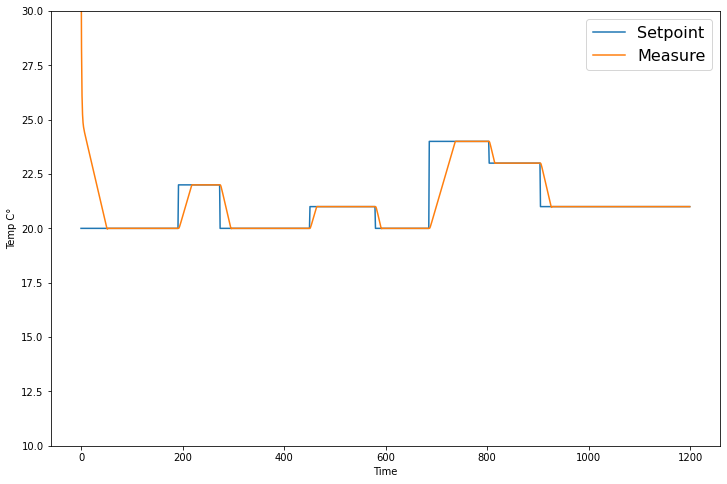

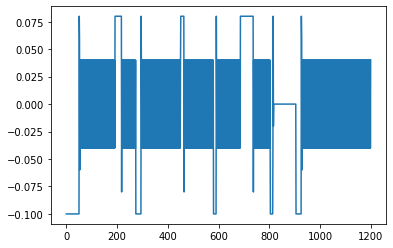

In [13]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Setpoint')
plt.plot(Temperature_grid, label='Measure')
plt.ylim((10, 30)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(Q1_grid)
plt.show()

# PID de referencia

In [14]:
%%time
# Parámetros
Ta = 25 # Se asume constante
T_inicial = 25
state = [T_inicial, 0] # Inicial
t_spam = [0, 1]
Tsp1 = setpoint
q_eval = np.arange(COLO, COHI, 0.1)

# arrays for storing data
Temperature_pid = np.zeros(loops) # measured T (degC)
error_pid = np.zeros(loops) # Setpoint error
Q1_pid = np.zeros(loops) # Controller values

# Integral error
ierr = 0.0

for i in range(loops):
    # Guardar temperatura
    Temperature_pid[i] = state[0]
    # Absolute error
    error_pid[i] =  np.abs(Tsp1[i]-Temperature_pid[i])

    # Calcular PID
    pv = Temperature_pid[i]
    pv_last = Temperature_pid[i-1] if i != 0 else pv
    [Q1_pid[i],P,ierr,D] = pid(Tsp1[i], pv, pv_last, ierr, 1)
    
    # Obtener temperatura dado el control PID y actualizar estado
    p = (Ta, Q1_pid[i])
    res = solve_ivp(tempModel, t_spam, state, args=p)
    state = [res.y[0][-1], res.y[1][-1]]

CPU times: user 581 ms, sys: 14.1 ms, total: 595 ms
Wall time: 589 ms


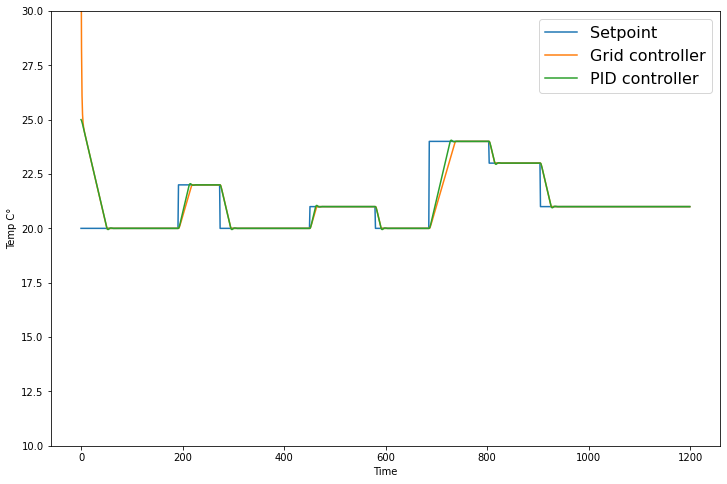

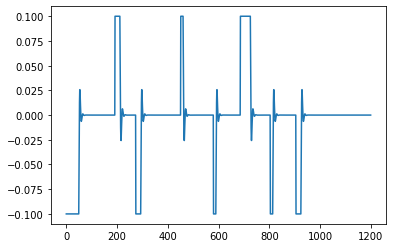

In [15]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Setpoint')
plt.plot(Temperature_grid, label='Grid controller')
plt.plot(Temperature_pid, label='PID controller')
plt.ylim((10, 30)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(Q1_pid)
plt.show()

# ML control from MPC

In [16]:
X_data = pd.read_csv('X_regression_final_2101.csv')
y_data = pd.read_csv('Y_regression_final_2101.csv')
print(X_data.head())
print(y_data.head())

   tiempo       temp  efecto_control  temp_ambiente  temp_objetivo  \
0     0.0  15.000000            0.00           10.0           15.0   
1     0.5  13.072917            0.25           10.0           15.0   
2     1.0  12.007595            0.50           10.0           15.0   
3     1.5  11.462922            0.75           10.0           15.0   
4     2.0  11.232807            1.00           10.0           15.0   

   temp_inicial  
0          15.0  
1          15.0  
2          15.0  
3          15.0  
4          15.0  
   tiempo            control
0     0.0  0.500000000000007
1     0.5  0.500000000000002
2     1.0  0.500000000000001
3     1.5   0.49999999999995
4     2.0  0.499999999999951


In [17]:
X_data = X_data[['temp', 'temp_ambiente', 'temp_objetivo']]
y_data = y_data[['control']]

## Datos de entrenamiento y prueba

Aquí revolvemos los datos y separamos los datos en entrenamiento y prueba.

In [18]:
split_size = 0.8
train_idxs = list(X_data.sample(frac=split_size).index)
test_idxs = list(X_data.index.difference(train_idxs))
X_train = X_data.loc[train_idxs,:]
X_test = X_data.loc[test_idxs,:]
y_train = y_data.loc[train_idxs,:]
y_test = y_data.loc[test_idxs,:]

Parámetros del sistema

In [19]:
Ta = 25 # Se asume constante
T_inicial = 25
Tsp1 = setpoint_ref['setpoint']

## MPC control

In [21]:
#Local
mpc_control_data = pd.read_csv('mpc_data_test_2.csv')
mpc_control_data.head()

,setpoint,temperatura,control
0,20,25.000000,0.5
1,20,25.052083,0.5
2,20,25.182509,-0.5
3,20,25.256099,-0.5
4,20,25.201601,-0.5


In [22]:
temperature_mpc = mpc_control_data['temperatura']

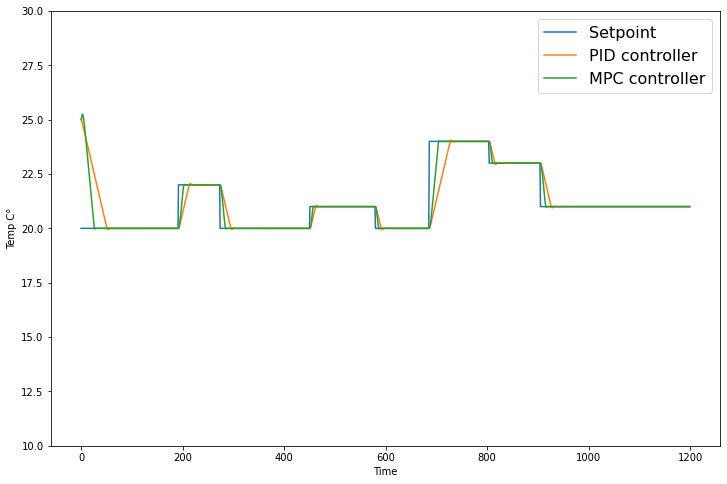

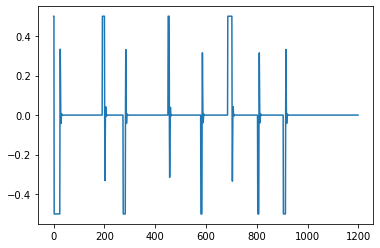

In [23]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Setpoint')
plt.plot(Temperature_pid, label='PID controller')
plt.plot(temperature_mpc, label='MPC controller')
plt.ylim((10, 30)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(mpc_control_data['control'])
plt.show()

## Lineal model mpc control

Regresión lineal

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
%%time
reg = LinearRegression().fit(X_data.values, y_data.values)

CPU times: user 61.6 ms, sys: 26.1 ms, total: 87.7 ms
Wall time: 91.2 ms


In [ ]:
reg.score(X_data.values, y_data.values)

0.5933333450943467

In [ ]:
reg.coef_

array([[-0.05427869, -0.00285861,  0.05579936]])

In [ ]:
reg.intercept_

array([0.03421603])

In [ ]:
X_train['temp_objetivo'].unique()

array([23, 26, 29, 17, 19, 28, 27, 18, 25, 21, 15, 30, 24, 16, 20, 22],
      dtype=int64)

In [ ]:
X = np.array([[18.5, 25, 20]])
reg.predict(X)[0][0]

0.07458232725845579

In [ ]:
%%time
# Parámetros
state = [T_inicial, 0] # Inicial
t_spam = [0, 1]

# arrays for storing data
temp_mpc_lm = np.zeros(loops) # measured T (degC)
error_lm = np.zeros(loops) # Setpoint error
Q1_lm = np.zeros(loops) # Controller values

for i in range(loops):
    # Guardar temperatura
    temp_mpc_lm[i] = state[0]
    # Absolute error
    error_lm[i] =  np.abs(Tsp1[i]-temp_mpc_lm[i])

    # Estimar control
    X = np.array([[temp_mpc_lm[i], Ta, Tsp1[i]]])
    Q1_lm[i] = reg.predict(X)[0][0]

    # Obtener temperatura dado el control PID y actualizar estado
    p = (Ta, Q1_lm[i])
    res = solve_ivp(tempModel, t_spam, state, args=p)
    state = [res.y[0][-1], res.y[1][-1]]

CPU times: total: 391 ms
Wall time: 425 ms


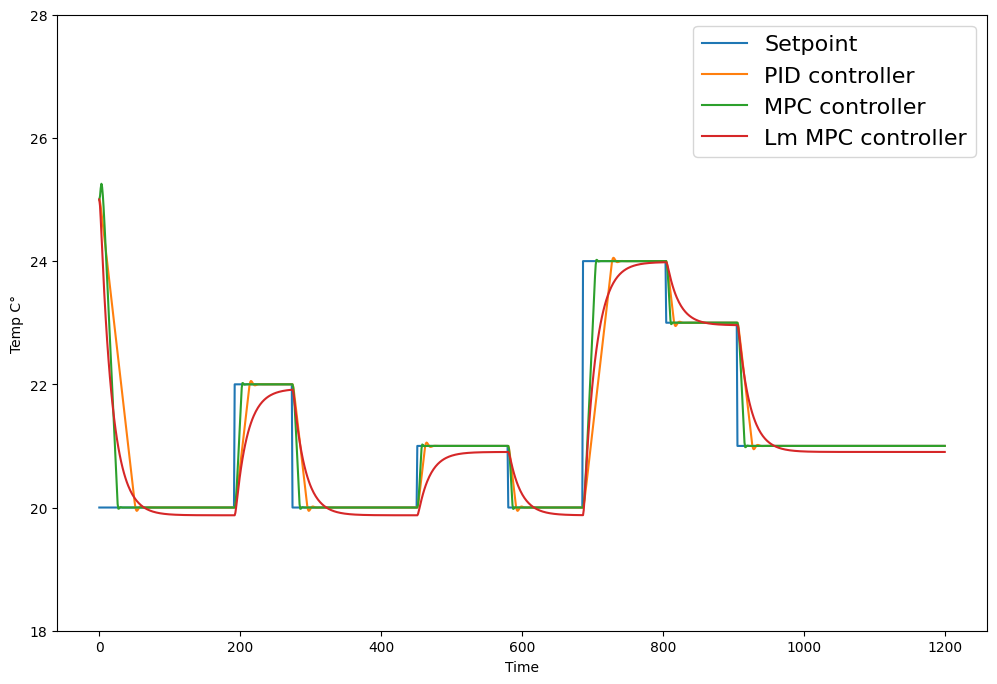

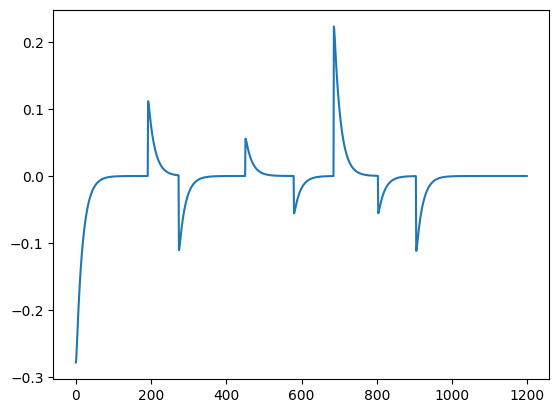

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Setpoint')
plt.plot(Temperature_pid, label='PID controller')
plt.plot(temperature_mpc, label='MPC controller')
plt.plot(temp_mpc_lm, label='Lm MPC controller')
plt.ylim((18, 28)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(Q1_lm)
plt.show()

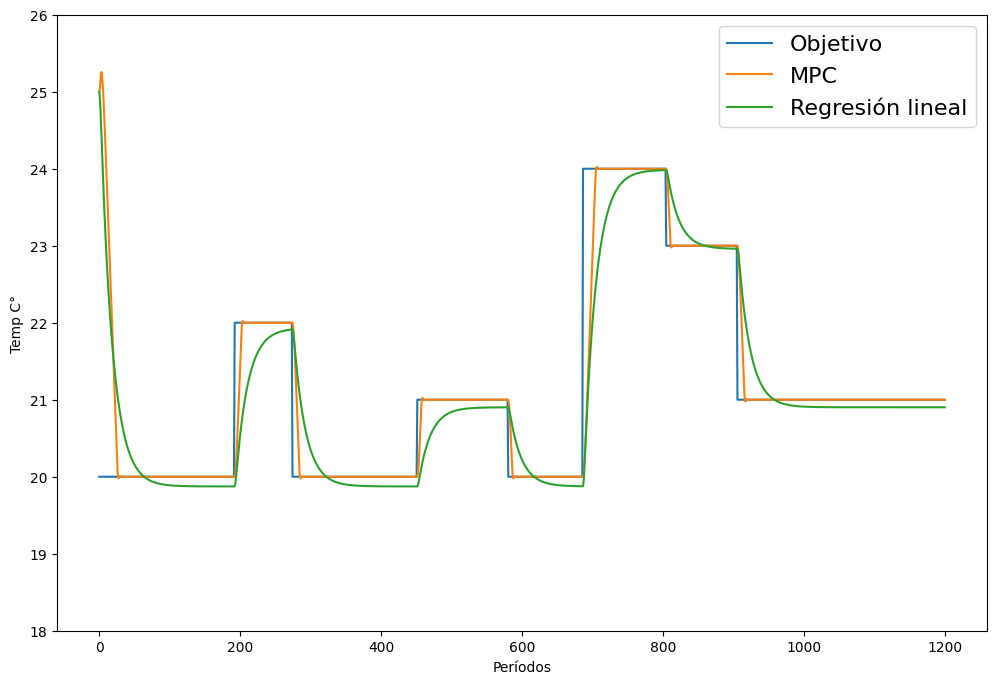

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Objetivo')
plt.plot(temperature_mpc, label='MPC')
plt.plot(temp_mpc_lm, label='Regresión lineal')
plt.ylim((18, 26)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Períodos')
plt.show()


## SVM mpc control

In [29]:
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
svm_scaled = make_pipeline(StandardScaler(), LinearSVR(random_state=0))
result = svm_scaled.fit(X_train.values, np.ravel(y_train.values))

CPU times: user 3min 35s, sys: 191 ms, total: 3min 35s
Wall time: 3min 36s


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
result[1].coef_

array([-2.84694420e-01,  1.77954280e-05,  2.79954839e-01])

In [ ]:
result[1].intercept_

array([-0.00451113])

In [ ]:
%%time
# Parámetros
state = [T_inicial, 0] # Inicial
t_spam = [0, 1]

# arrays for storing data
temp_mpc_svm = np.zeros(loops) # measured T (degC)
error_svm = np.zeros(loops) # Setpoint error
Q1_svm = np.zeros(loops) # Controller values

for i in range(loops):
    # Guardar temperatura
    temp_mpc_svm[i] = state[0]
    # Absolute error
    error_svm[i] =  np.abs(Tsp1[i]-temp_mpc_svm[i])

    # Estimar control
    X = np.array([[temp_mpc_svm[i], Ta, Tsp1[i]]])
    Q1_svm[i] = svm_scaled.predict(X)[0]

    # Obtener temperatura dado el control PID y actualizar estado
    p = (Ta, Q1_svm[i])
    res = solve_ivp(tempModel, t_spam, state, args=p)
    state = [res.y[0][-1], res.y[1][-1]]

CPU times: total: 1.25 s
Wall time: 1.26 s


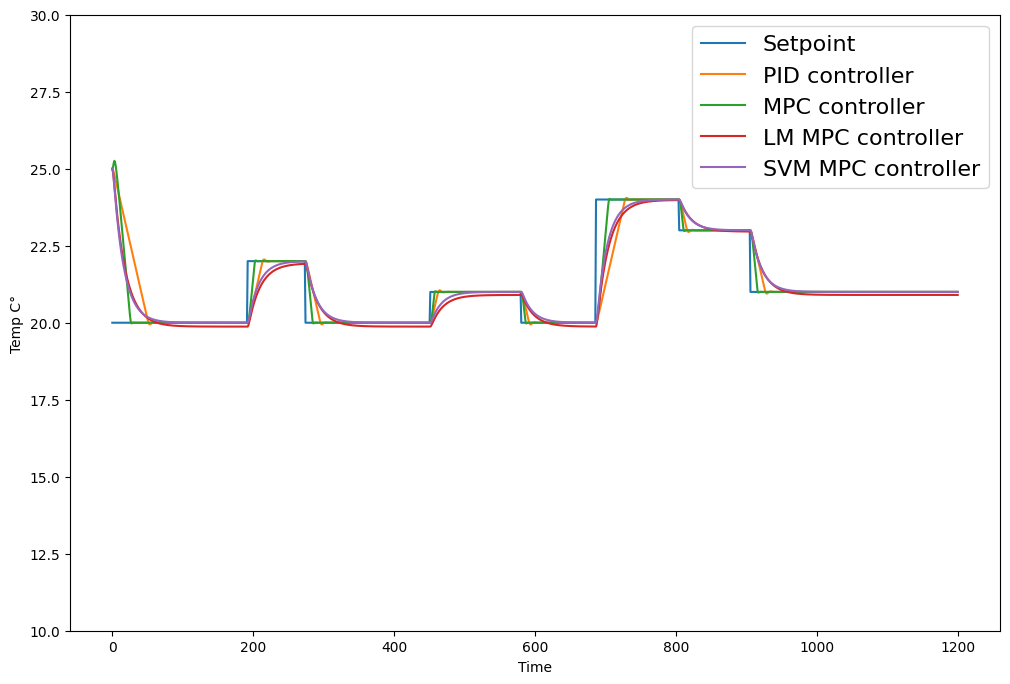

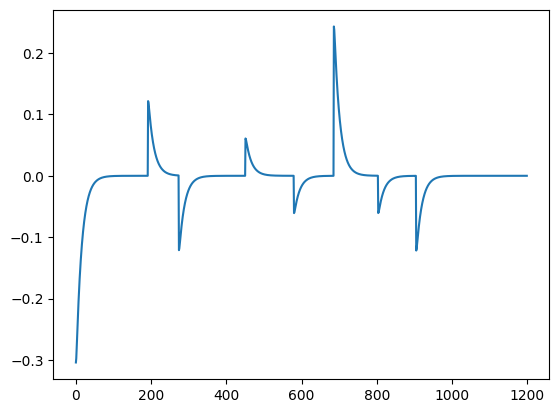

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Setpoint')
plt.plot(Temperature_pid, label='PID controller')
plt.plot(temperature_mpc, label='MPC controller')
plt.plot(temp_mpc_lm, label='LM MPC controller')
plt.plot(temp_mpc_svm, label='SVM MPC controller')
plt.ylim((10, 30)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Time')
plt.show()

plt.figure()
plt.plot(Q1_svm)
plt.show()

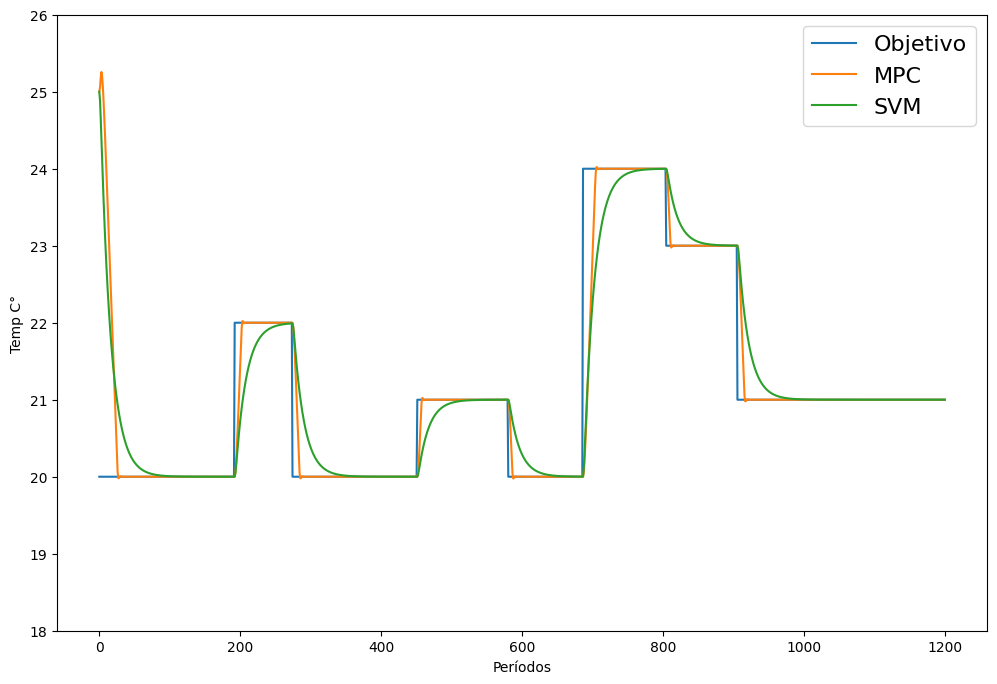

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Objetivo')
plt.plot(temperature_mpc, label='MPC')
plt.plot(temp_mpc_svm, label='SVM')
plt.ylim((18, 26)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Períodos')
plt.show()


## Neural network

In [30]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 8.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=66c5f466a8db4812e0f9fb5596e75474f0b89561bb884c333933c8a40440b202
  Stored in directory: /root/.cache/pip/wheels/4b/ef/77/9b8c4ae2f9a11de19957b80bc5c684accd99114bb8dc6b374c
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras import backend

In [26]:
# Get Neural network train data
X_train_nn = pd.read_csv('X_regression_final_3.csv')
y_train_nn = pd.read_csv('Y_regression_final_3.csv')
X_train_nn = X_train_nn[['temp', 'temp_ambiente', 'temp_objetivo']]
y_train_nn = y_train_nn[['control']]

In [27]:
# Clear
backend.clear_session()

# Build neural network
input_cols = X_train.shape[1]
NN_model = Sequential()
callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=input_cols))
NN_model.add(BatchNormalization())
NN_model.add(Activation('linear'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='linear'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='linear'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='linear'))
NN_model.add(Dense(32, kernel_initializer='normal',activation='linear'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                        

In [31]:
%%time
# Estandarizar datos para entrenar la red
scaler_nn = StandardScaler().fit(X_train_nn.values)
X_train_sca = scaler_nn.transform(X_train_nn.values)
# Entrenar
history = NN_model.fit(X_train_sca, y_train_nn, epochs=100, batch_size=32,
             validation_split = 0.2,
             callbacks=[callback])

Epoch 1/100
629/629 [==============================] - 12s 13ms/step - loss: 0.0517 - mean_absolute_error: 0.0517 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475
Epoch 2/100
629/629 [==============================] - 9s 14ms/step - loss: 0.0488 - mean_absolute_error: 0.0488 - val_loss: 0.0510 - val_mean_absolute_error: 0.0510
Epoch 3/100
629/629 [==============================] - 8s 12ms/step - loss: 0.0479 - mean_absolute_error: 0.0479 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 4/100
629/629 [==============================] - 6s 9ms/step - loss: 0.0474 - mean_absolute_error: 0.0474 - val_loss: 0.0683 - val_mean_absolute_error: 0.0683
Epoch 5/100
629/629 [==============================] - 4s 6ms/step - loss: 0.0473 - mean_absolute_error: 0.0473 - val_loss: 0.0529 - val_mean_absolute_error: 0.0529
Epoch 6/100
629/629 [==============================] - 6s 9ms/step - loss: 0.0472 - mean_absolute_error: 0.0472 - val_loss: 0.0490 - val_mean_absolute_error: 0.0490
Epoch 

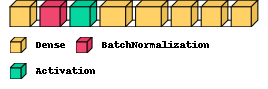

In [37]:
# Visualizacion de la red neuronal
import visualkeras
from PIL import ImageFont
# font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(NN_model, legend=True,to_file='arquitectura red neuronal.png') # selected font

In [ ]:
# Save model
pickle.dump(NN_model, open('NN_model.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\dense_5
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
Fi

In [ ]:
%%time
# Parámetros
state = [T_inicial, 0] # Inicial
t_spam = [0, 1]

# arrays for storing data
temp_mpc_nn = np.zeros(loops) # measured T (degC)
error_nn = np.zeros(loops) # Setpoint error
Q1_nn = np.zeros(loops) # Controller values

for i in range(loops):
    # Guardar temperatura
    temp_mpc_nn[i] = state[0]
    # Absolute error
    error_nn[i] =  np.abs(Tsp1[i]-temp_mpc_nn[i])

    # Estimar control
    X = np.array([[temp_mpc_nn[i], Ta, Tsp1[i]]])
    X = scaler_nn.transform(X) # Estandarizar
    Q1_nn[i] = NN_model.predict(X, verbose=0)[0][0]

    # Obtener temperatura dado el control PID y actualizar estado
    p = (Ta, Q1_nn[i])
    res = solve_ivp(tempModel, t_spam, state, args=p)
    state = [res.y[0][-1], res.y[1][-1]]

CPU times: total: 60 s
Wall time: 56.3 s


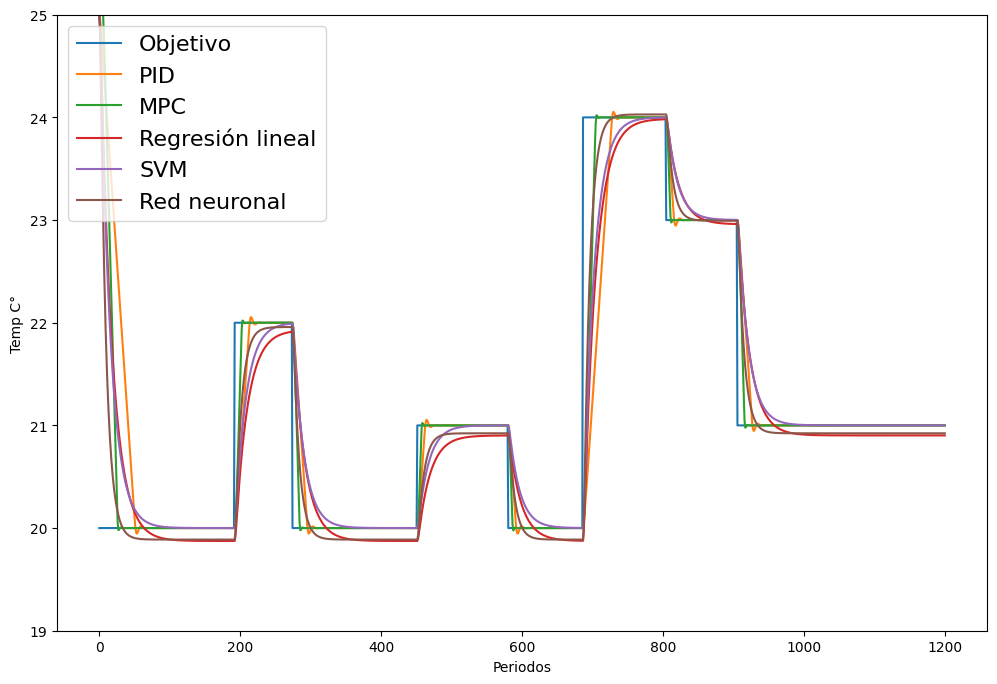

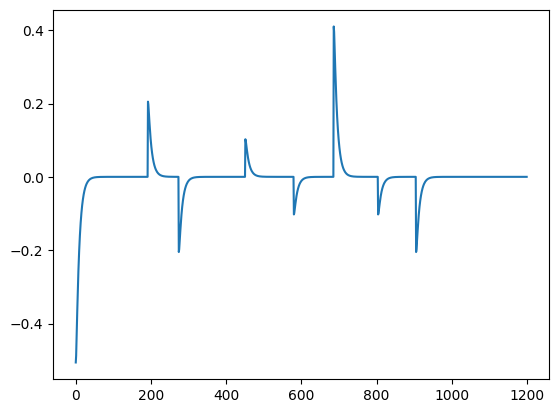

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Objetivo')
plt.plot(Temperature_pid, label='PID')
plt.plot(temperature_mpc, label='MPC')
plt.plot(temp_mpc_lm, label='Regresión lineal')
plt.plot(temp_mpc_svm, label='SVM')
plt.plot(temp_mpc_nn, label='Red neuronal')
plt.ylim((19, 25)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Periodos')
plt.show()

plt.figure()
plt.plot(Q1_nn)
plt.show()

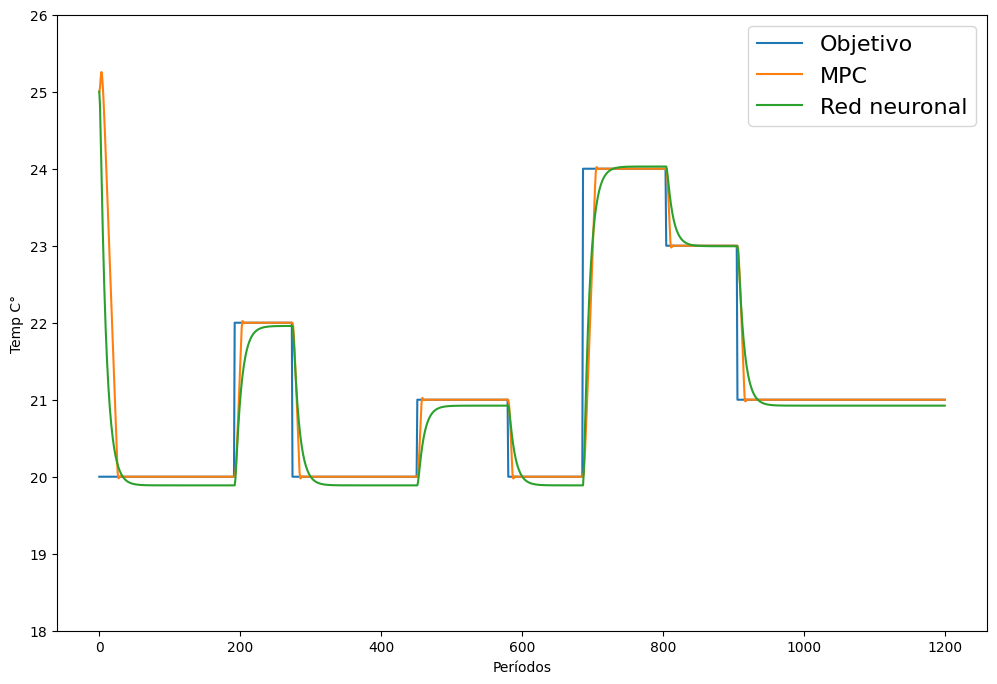

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Objetivo')
plt.plot(temperature_mpc, label='MPC')
plt.plot(temp_mpc_nn, label='Red neuronal')
plt.ylim((18, 26)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Períodos')
plt.show()


Text(0.5, 0, 'Épocas')

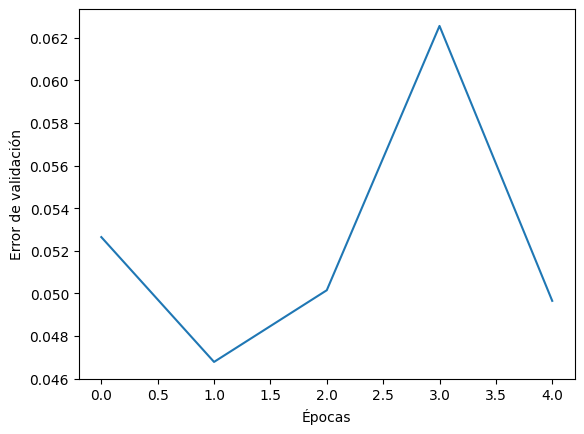

In [ ]:
plt.plot(history.history['val_loss'])
plt.ylabel('Error de validación'); plt.xlabel('Épocas')

## Testear modelos

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

Comparar datos del control

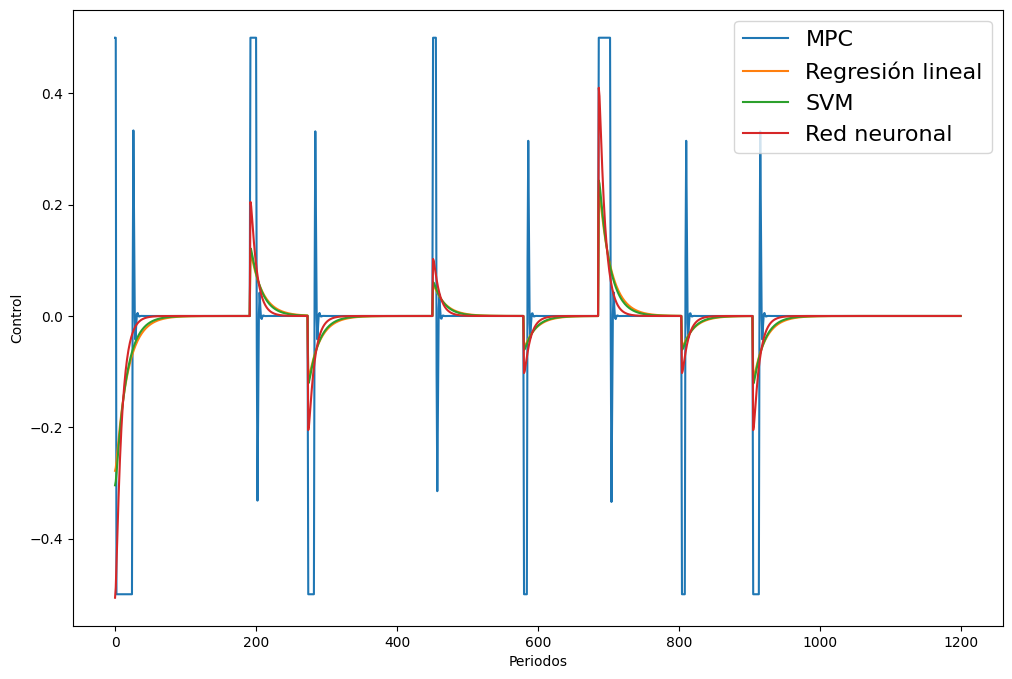

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(mpc_control_data['control'], label='MPC')
plt.plot(Q1_lm, label='Regresión lineal')
plt.plot(Q1_svm, label='SVM')
plt.plot(Q1_nn, label='Red neuronal')
plt.ylabel('Control'); plt.xlabel('Periodos')
plt.legend(prop={'size': 16})
plt.show()

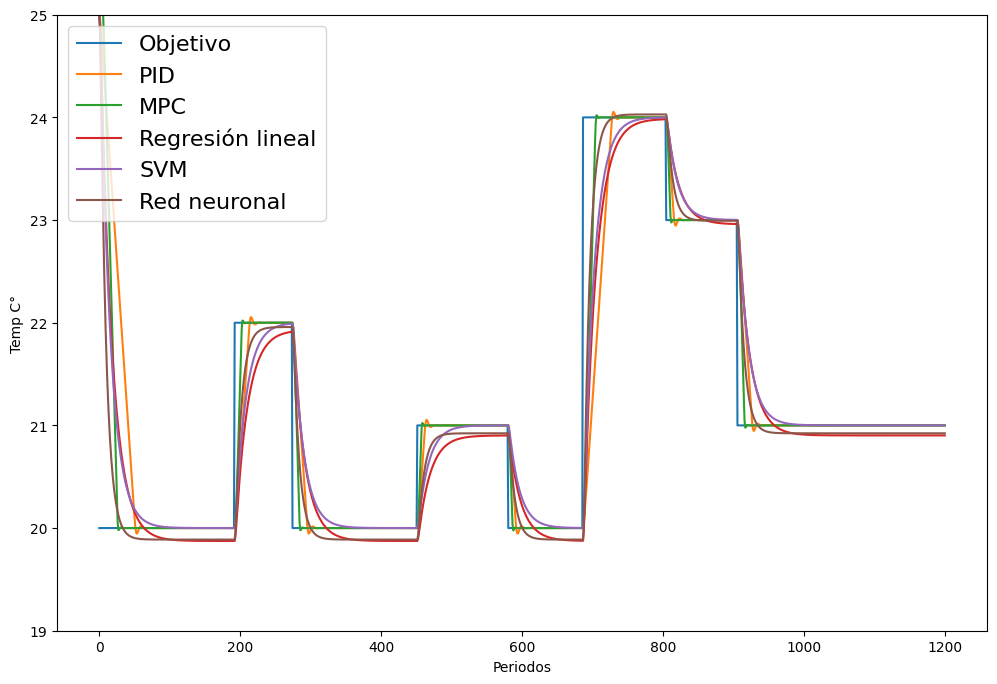

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(Tsp1, label='Objetivo')
plt.plot(Temperature_pid, label='PID')
plt.plot(temperature_mpc, label='MPC')
plt.plot(temp_mpc_lm, label='Regresión lineal')
plt.plot(temp_mpc_svm, label='SVM')
plt.plot(temp_mpc_nn, label='Red neuronal')
plt.ylim((19, 25)); plt.legend(prop={'size': 16})
plt.ylabel('Temp C°'); plt.xlabel('Periodos')
plt.show()

In [ ]:
print('MSE entre la temperatura objetivo y la de cada modelo')
print('Parámetros: temperatura inicial y ambiente de 25C°')
print('MPC:', mean_squared_error(Tsp1, temperature_mpc))
print('PID:', mean_squared_error(Tsp1, Temperature_pid))
print('Red Neuronal:', mean_squared_error(Tsp1, temp_mpc_nn))
print('SVM:', mean_squared_error(Tsp1, temp_mpc_svm))
print('Regresión lineal:', mean_squared_error(Tsp1, temp_mpc_lm))

MSE entre la temperatura objetivo y la de cada modelo
Parámetros: temperatura inicial y ambiente de 25C°
MPC: 0.43613764996213583
PID: 0.6686162235751414
Red Neuronal: 0.2783194063314701
SVM: 0.4191699538352896
Regresión lineal: 0.4705432268263912


MISE
La integral la saca por la regla del trapezoide

In [ ]:
def mise(y1, y2):
    return np.trapz(np.cumsum(np.square(y1 - y2)))/len(y1)

In [ ]:
print('MISE entre la temperatura objetivo y la de cada modelo')
print('Parámetros: temperatura inicial y ambiente de 25C°')
print('MPC:', mise(Tsp1, temperature_mpc))
print('PID:', mise(Tsp1, Temperature_pid))
print('Red Neuronal:', mise(Tsp1, temp_mpc_nn))
print('SVM:', mise(Tsp1, temp_mpc_svm))
print('Regresión lineal:', mise(Tsp1, temp_mpc_lm))

MISE entre la temperatura objetivo y la de cada modelo
Parámetros: temperatura inicial y ambiente de 25C°
MPC: 424.29554870863825
PID: 615.0694403138066
Red Neuronal: 239.1889465900067
SVM: 362.85987307951694
Regresión lineal: 402.82769303506063


### MSE y R2 para los datos de prueba como en ML

In [ ]:
y_test.shape

(266240, 1)

In [ ]:
X_test.shape

(266240, 3)

Predicciones en datos de prueba

In [ ]:
%%time
lm_test_pred = reg.predict(X_test.values)

CPU times: total: 15.6 ms
Wall time: 10.8 ms


In [ ]:
%%time
svm_test_pred = svm_scaled.predict(X_test.values).reshape([-1, 1])

CPU times: total: 0 ns
Wall time: 11.4 ms


In [ ]:
%%time
X = scaler_nn.transform(X_test.values)
nn_test_pred = NN_model.predict(X, verbose=0)

CPU times: total: 17.5 s
Wall time: 12.7 s


In [ ]:
print('Métricas ML regresión lineal')
print('Mean Square Error:', mean_squared_error(y_test, lm_test_pred))
print('R square:', r2_score(y_test, lm_test_pred))

print('Métricas ML SVM')
print('Mean Square Error:', mean_squared_error(y_test, svm_test_pred))
print('R square:', r2_score(y_test, svm_test_pred))

print('Métricas Red neuronal')
print('Mean Square Error:', mean_squared_error(y_test, nn_test_pred))
print('R square:', r2_score(y_test, nn_test_pred))

Métricas ML regresión lineal
Mean Square Error: 0.017158594638561432
R square: 0.5929307993776687
Métricas ML SVM
Mean Square Error: 0.017668394328141532
R square: 0.5808363501243188
Métricas Red neuronal
Mean Square Error: 0.030800317131504308
R square: 0.26929560737691505


# Testear tiempos

In [ ]:
import time

In [ ]:
def iter_model(state, t_spam, num_steps, t_obj, model):
    # arrays for storing data
    temp_mpc_t = np.zeros(num_steps) # measured T (degC)
    error_t = np.zeros(num_steps) # Setpoint error
    Q1_t = np.zeros(num_steps) # Controller values

    for i in range(num_steps):
        # Guardar temperatura
        temp_mpc_t[i] = state[0]
        # Absolute error
        error_t[i] =  np.abs(t_obj-temp_mpc_t[i])

        # Estimar control
        X = np.array([[temp_mpc_t[i], Ta, t_obj]])
        if model == 'NN':
            X = scaler_nn.transform(X) # Estandarizar
            Q1_t[i] = NN_model.predict(X, verbose=0)[0][0]
        elif model == 'SVM':
            Q1_t[i] = svm_scaled.predict(X)[0]
        else: #Regresión lineal
            Q1_t[i] = reg.predict(X)[0][0]

        # Obtener temperatura dado el control PID y actualizar estado
        p = (Ta, Q1_t[i])
        res = solve_ivp(tempModel, t_spam, state, args=p)
        state = [res.y[0][-1], res.y[1][-1]]

    return temp_mpc_t

In [ ]:
# Parámetros
T_inicial = 25
Ta = 25 # Temperatura inicial
objetivo = list(range(10, 35, 2))
state = [T_inicial, 0] # Inicial
t_spam = [0, 1]
num_steps = 100

In [ ]:
%%time
cpu_times = {}
for model in ['NN', 'SVM', 'LM']:
    cpu_times[model] = {}
    for t_obj in objetivo:
        start = time.process_time()
        _ = iter_model(state, t_spam, num_steps, t_obj, model)
        cpu_time_sec = time.process_time() - start
        cpu_times[model][t_obj] = cpu_time_sec


CPU times: total: 1min 3s
Wall time: 1min


In [ ]:
print(cpu_times)

{'NN': {10: 5.140625, 12: 4.96875, 14: 4.828125, 16: 4.515625, 18: 4.828125, 20: 4.75, 22: 4.625, 24: 4.6875, 26: 4.921875, 28: 5.015625, 30: 5.046875, 32: 4.796875, 34: 4.578125}, 'SVM': {10: 0.03125, 12: 0.03125, 14: 0.03125, 16: 0.03125, 18: 0.03125, 20: 0.03125, 22: 0.046875, 24: 0.03125, 26: 0.03125, 28: 0.03125, 30: 0.03125, 32: 0.03125, 34: 0.03125}, 'LM': {10: 0.03125, 12: 0.03125, 14: 0.03125, 16: 0.03125, 18: 0.015625, 20: 0.03125, 22: 0.03125, 24: 0.015625, 26: 0.03125, 28: 0.03125, 30: 0.015625, 32: 0.03125, 34: 0.03125}}
